# Data Preparation

In [45]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torchvision

In [46]:
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join
## MNIST Data Loader Class#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                    test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)   


In [47]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [48]:
training_images_filepath = '/Users/doanhaidang1703/Documents/AIO/AIO Code/Module 6/data_mnist/data/train-images.idx3-ubyte'
training_labels_filepath = '/Users/doanhaidang1703/Documents/AIO/AIO Code/Module 6/data_mnist/data/train-labels.idx1-ubyte'
test_images_filepath =     '/Users/doanhaidang1703/Documents/AIO/AIO Code/Module 6/data_mnist/data/t10k-images.idx3-ubyte'
test_labels_filepath =     '/Users/doanhaidang1703/Documents/AIO/AIO Code/Module 6/data_mnist/data/t10k-labels.idx1-ubyte'

In [49]:
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

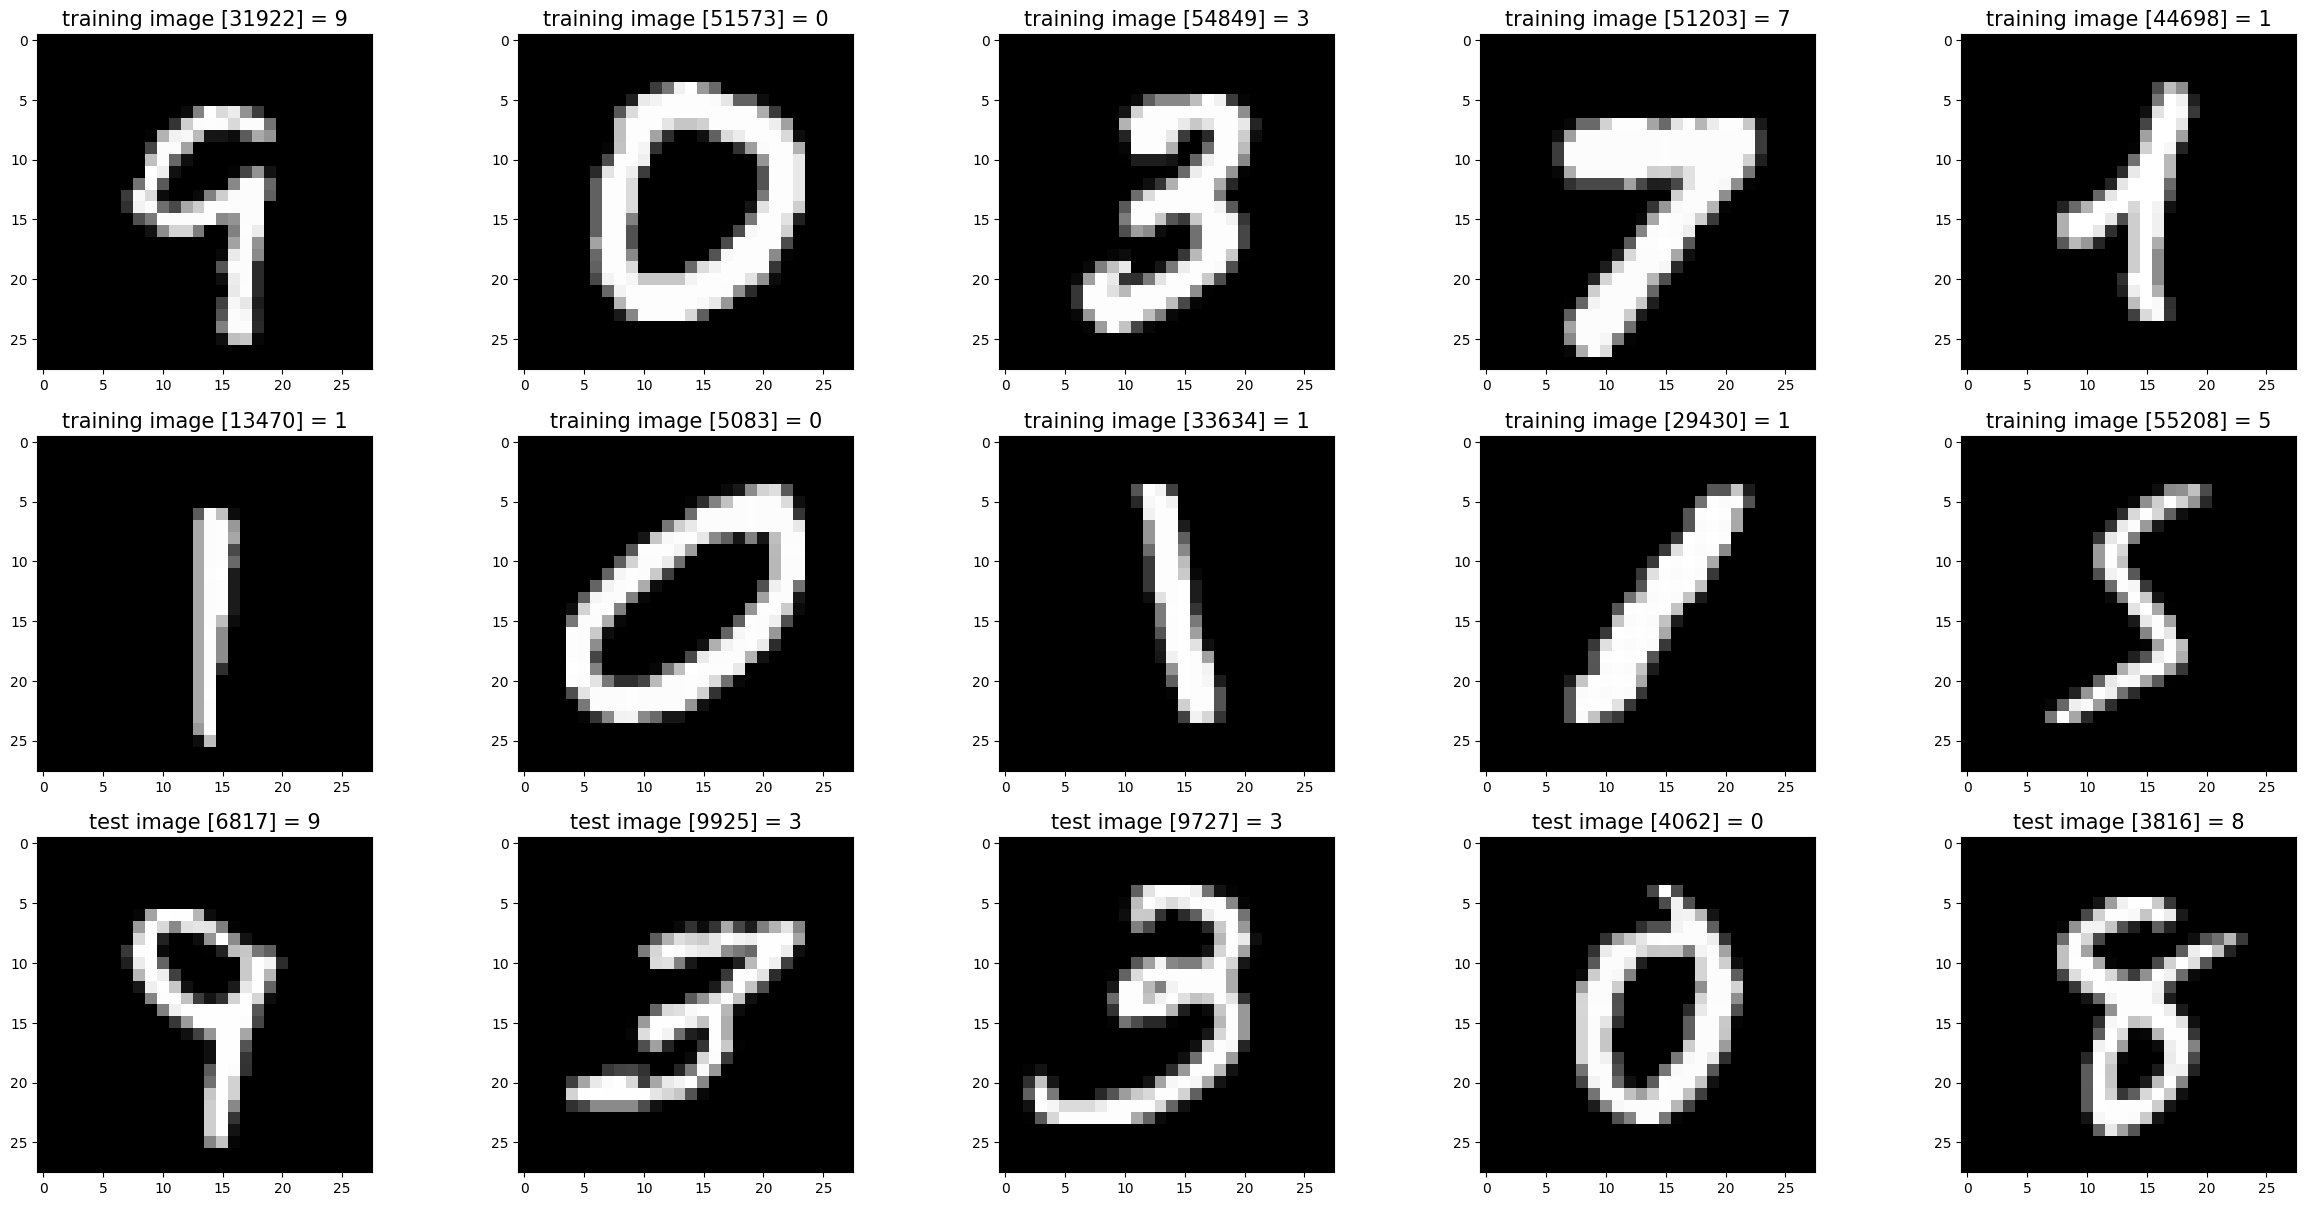

In [50]:
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [51]:
from torch.utils.data import TensorDataset, DataLoader

mnist_loader = MnistDataloader(
    training_images_filepath, training_labels_filepath,
    test_images_filepath, test_labels_filepath
)
(x_train, y_train), (x_test, y_test) = mnist_loader.load_data()

x_train_tensor = torch.tensor(np.array(x_train), dtype=torch.float32) / 255.0
y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.long)

x_test_tensor = torch.tensor(np.array(x_test), dtype=torch.float32) / 255.0
y_test_tensor = torch.tensor(np.array(y_test), dtype=torch.long)

# 3. Add a channel dimension (N, 28, 28) -> (N, 1, 28, 28)
# PyTorch CNNs expect the channel dimension (1 for grayscale)
x_train_tensor = x_train_tensor.unsqueeze(1)
x_test_tensor = x_test_tensor.unsqueeze(1)

print(f"Train shape: {x_train_tensor.shape}")  # Should be [60000, 1, 28, 28]
print(f"Test shape: {x_test_tensor.shape}")    # Should be [10000, 1, 28, 28]


Train shape: torch.Size([60000, 1, 28, 28])
Test shape: torch.Size([10000, 1, 28, 28])


In [52]:

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)


trainloader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

testloader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [53]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256,256),
    nn.ReLU(),
    nn.Linear(256,10)
)

model = model.to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=10, bias=True)
)


In [54]:
def evaluation(model, testloader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for (images, labels) in testloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predicted = torch.argmax(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct/total
    test_loss = test_loss/len(testloader)
    return accuracy, test_loss

In [55]:
accuracy, test_loss = evaluation(model, testloader, criterion)
print(accuracy)
print(test_loss)

7.36
2.306805584840714


In [56]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 150

In [57]:
for epoch in range(max_epoch):
    running_loss = 0.0 #loss in an epoch
    running_correct = 0.0 #track accuracy during an epoch
    total = 0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        #move inputs and labels to device
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        predicted = torch.argmax(outputs.data, 1)
    
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        loss.backward()
        optimizer.step()
    
    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    test_accuracy, test_loss = evaluation(model, testloader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/150], Loss: 1.6261, Accuracy: 60.68%, Test Loss: 0.7040, Test Accuracy: 82.96%
Epoch [2/150], Loss: 0.5251, Accuracy: 86.12%, Test Loss: 0.4052, Test Accuracy: 88.74%
Epoch [3/150], Loss: 0.3816, Accuracy: 89.27%, Test Loss: 0.3350, Test Accuracy: 90.45%
Epoch [4/150], Loss: 0.3330, Accuracy: 90.59%, Test Loss: 0.3006, Test Accuracy: 91.30%
Epoch [5/150], Loss: 0.3047, Accuracy: 91.29%, Test Loss: 0.2813, Test Accuracy: 91.86%
Epoch [6/150], Loss: 0.2830, Accuracy: 91.89%, Test Loss: 0.2612, Test Accuracy: 92.53%
Epoch [7/150], Loss: 0.2647, Accuracy: 92.44%, Test Loss: 0.2467, Test Accuracy: 92.98%
Epoch [8/150], Loss: 0.2482, Accuracy: 92.92%, Test Loss: 0.2336, Test Accuracy: 93.35%
Epoch [9/150], Loss: 0.2333, Accuracy: 93.34%, Test Loss: 0.2187, Test Accuracy: 93.68%
Epoch [10/150], Loss: 0.2191, Accuracy: 93.79%, Test Loss: 0.2121, Test Accuracy: 93.78%
Epoch [11/150], Loss: 0.2066, Accuracy: 94.13%, Test Loss: 0.1970, Test Accuracy: 94.28%
Epoch [12/150], Loss: 0.1951, 

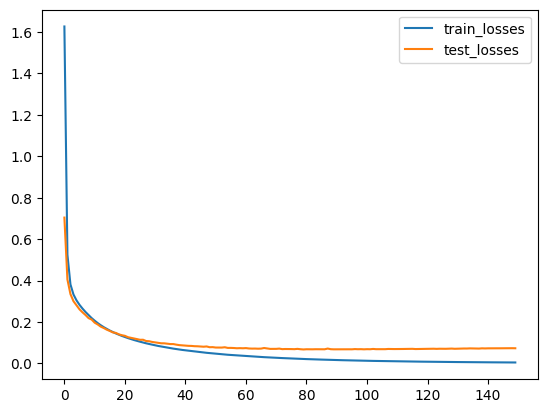

In [58]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

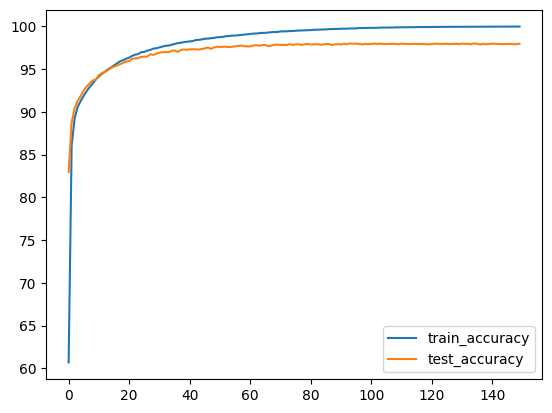

In [59]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()

In [60]:
accuracy, test_loss = evaluation(model, testloader, criterion)
print(accuracy)
print(test_loss)

97.97
0.07349431615471452


In [63]:
model.eval()
with torch.no_grad():
   
    inputs = x_test_tensor.to(device) 
    
   
    predictions = model(inputs)
    predictions_cpu = predictions.cpu()
    
    # 4. Now perform the argmax
    prediction_labels = np.argmax(predictions_cpu, axis=1)
    count = 0
    for i in range(y_test_tensor.shape[0]):
        if (prediction_labels[i] != y_test[i]):
            count += 1
    print(f"Number of wrong prediction: {count}")
    print(f"Number of test sample: {y_test_tensor.shape[0]}")


Number of wrong prediction: 203
Number of test sample: 10000
